In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import scipy.signal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [67]:
import os
import base64
import codecs
from PIL import Image
import imageio
from io import BytesIO

In [68]:
def create_b64_images(im_path='images', im64_path='images64'):
    img_paths = []
    for d, _, f in os.walk(im_path):
        for file in f:
            img_path = os.path.join(d, file)

            with open(img_path, 'rb') as image_file:
                data = base64.b64encode(image_file.read())
                
            im = Image.open(BytesIO(base64.b64decode(data)))
            im_64_path_name = os.path.join(im64_path,
                                      file.split('.')[0]+'_b64.png')
            print('Updated...', im_64_path_name)
            img_paths.append(im_64_path_name)
            im.save(im_64_path_name)
    return img_paths
im_new_paths = create_b64_images()

Updated... images64\f0_b64.png
Updated... images64\f1_b64.png
Updated... images64\f2_b64.png
Updated... images64\f3_b64.png
Updated... images64\f4_b64.png
Updated... images64\f5_b64.png


In [69]:
im_new_paths[0]

'images64\\f0_b64.png'

In [70]:
def show_fractal(image_path):
    
    image = cv2.imread(image_path)
    
    gray = gray_image(image)
    
    plot_otsu_thresh(image)
    
    Z = 1.0 - gray/255.
    sizes = 128, 64, 28
    
    # sizes = 32, 16, 8
    xmin, xmax = 0, Z.shape[1]
    ymin, ymax = 0, Z.shape[0]
    fig = plt.figure(figsize=(16, 11))
    plt.title('Box Counting Fractal Method')
    for i, size in enumerate(sizes):
        ax = plt.subplot(1, len(sizes), i+1, frameon=False)
        ax.imshow(1-Z, plt.cm.gray, interpolation="bicubic", vmin=0, vmax=1,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")
        ax.set_xticks([])
        ax.set_yticks([])
        for y in range(Z.shape[0]//size+1):
            for x in range(Z.shape[1]//size+1):
                s = (Z[y*size:(y+1)*size, x*size:(x+1)*size] > 0.25).sum()
                if s > 0 and s < size*size:
                    rect = patches.Rectangle(
                        (x*size, Z.shape[0]-1-(y+1)*size),
                        width=size, height=size,
                        linewidth=.5, edgecolor='.25',
                        facecolor='.75', alpha=.5, color='lightblue')
                    ax.add_patch(rect)
                    
    

    plt.tight_layout()
    

    print("The Fractal dimension of the coastline image is {}".format(
        fractal_dimension(Z, threshold=0.1)))

In [81]:
class fractal_report_analysis:
    
    def __init__(self, im_path, report_path):
        self.im_path = im_path
        self.im_name = im_path.split('\\')[1].split('.')[0]
        self.report_path = report_path+'\\'
        self.im_report_paths_list = []
        self.image = cv2.imread(self.im_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
    
    def hsv_graph_3d(self):
    
        hsv_name = self.report_path+self.im_name+'_hsv_report.jpg'
        
        
        im_demo = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        im_demo = cv2.cvtColor(im_demo, cv2.COLOR_RGB2HSV)

        pixel_colors = im_demo.reshape((np.shape(im_demo)[0]*np.shape(im_demo)[1], 3))
        norm = colors.Normalize(vmin=-1.,vmax=1.)
        norm.autoscale(pixel_colors)
        pixel_colors = norm(pixel_colors).tolist()

        h, s, v = cv2.split(im_demo)
        fig = plt.figure()
        axis = fig.add_subplot(1, 1, 1, projection="3d")

        axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
        axis.set_xlabel("Hue")
        axis.set_ylabel("Saturation")
        axis.set_zlabel("Value")
        
        plt.title('hsv color analysis')
        
        plt.savefig(hsv_name)
        
        self.im_report_paths_list.append(hsv_name)
        
        
    def otsu_thresh_image(self):
    
        blur = cv2.GaussianBlur(self.gray,(5,5),0)

        _, th3 = cv2.threshold(blur, 0, 255,
                                 cv2.THRESH_BINARY+cv2.THRESH_OTSU)


        # map thresholding
        fig = plt.figure(figsize=(15, 5))
        images = [blur, 0, th3]
        titles = ["Gaussian filtered Image",
                  "Intensity Histogram",
                  "Otsu's Thresholding"]

        plt.subplot(1,3,1)
        plt.imshow(images[0], 'gray')
        plt.title(titles[0])
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,2)
        plt.hist(images[0].ravel(), 256)
        plt.title('White light Intensity Histogram')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,3)
        plt.imshow(images[2], 'gray')
        plt.title(titles[2])
        plt.xticks([])
        plt.yticks([])
        
        otsu_thresh_im = self.report_path+self.im_name+titles[2]+'.jpg'
        
        plt.savefig(otsu_thresh_im)
        plt.close(fig)
        
        self.im_report_paths_list.append(otsu_thresh_im)
        
        
    def im2col(self, A, BLKSZ):   

        # Parameters
        M,N = A.shape
        col_extent = N - BLKSZ[1] + 1
        row_extent = M - BLKSZ[0] + 1

        # Get Starting block indices
        start_idx = np.arange(BLKSZ[0])[:,None]*N + np.arange(BLKSZ[1])

        # Get offsetted indices across the height and width of input array
        offset_idx = np.arange(row_extent)[:,None]*N + np.arange(col_extent)

        # Get all actual indices & index into input array for final output
        return np.take (A,start_idx.ravel()[:,None] + offset_idx.ravel())

    def coltfilt(self, A, size):
        original_shape = np.shape(A)
        a,b = 0, 0
        if(size%2==0):
            a, b = int(size/2)-1, int(size/2)
        else:
            a,b = int(size/2), int(size/2)
        A = np.lib.pad(A, (a, b), 'constant')
        Acol = self.im2col(A, (size, size))
        rc = np.floor((Acol.max(axis=0) - Acol.min(axis=0))/float(size)) + 1
        return np.reshape(rc, original_shape)

    def matlab_style_gauss2D(self, shape=(3,3),sigma=0.5):
        """
        2D gaussian mask - should give the same result as MATLAB's
        fspecial('gaussian',[shape],[sigma])
        """
        m,n = [(ss-1.)/2. for ss in shape]
        y,x = np.ogrid[-m:m+1,-n:n+1]
        h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
        h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
        sumh = h.sum()
        if sumh != 0:
            h /= sumh
        return h

    def mat2gray(self, mat):
        maxI = np.max(mat)
        minI = np.min(mat)
        gray = (mat[:,:] - minI) / (maxI - minI)
        return gray
    
    def fractal_transformation(self):
        
        imrows, imcols = np.shape(self.gray)
        
        B = np.zeros((6, imrows, imcols))

        print("Calculating Differential Box Counting image")

        for r in range(2,8):
            mask = self.matlab_style_gauss2D((r,r), r/2.0)
            im = scipy.signal.convolve2d(self.gray, mask, mode='same')
            F = (self.coltfilt(im, r))*(49/(r**2))
            B[r - 2] = np.log(F)


        #------- computing the slope using linear regression -------

        print("Calculating FD image")

        i = np.log(range(2,8)) #Normalised scale range vector

        Nxx = np.dot(i,i) - (np.sum(i)**2)/6
        FD = np.zeros((imrows,imcols))

        for m in range(1,imrows):
            for n in range(1,imcols):
                fd = [B[5,m,n], B[4,m,n], B[3,m,n], B[2,m,n], B[1,m,n], B[0,m,n]] #Number of boxes multiscale vector
                Nxy = np.dot(i,fd) - (sum(i)*sum(fd))/6
                FD[m,n] = Nxy/Nxx # slope of the linear regression line

        tmp = np.zeros(np.shape(B))
        for r in range(2,8):
            tmp[r-2, :, :] = FD * np.log(m)

        intercept = np.mean(B - tmp, axis=0)

        FDB = self.mat2gray(FD);

        intercept_image = self.mat2gray(intercept)

        fig = plt.figure(figsize=(30,20))
        
        plt.imshow(intercept_image, cmap='gray')
        
        fd_name = self.report_path+self.im_name+'_fd_tran.jpg'
        plt.savefig(fd_name)
        
        plt.close(fig)
        
        self.im_report_paths_list.append(fd_name)
        

In [82]:
fr = fractal_report_analysis(im_new_paths[0], 'report_images')
#fr.hsv_graph_3d()
#fr.otsu_thresh_image()
fr.fractal_transformation()

Calculating Differential Box Counting image
Calculating FD image


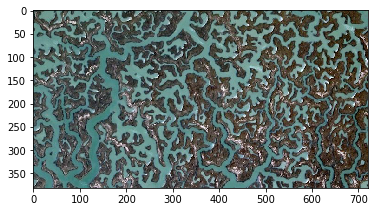

In [11]:
# generating mask for satellite images
f0 = cv2.imread(im_new_paths[0])
plot_image_cv2(f0)